# Metadata

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
Date:     14 February 2022 (revised and improved)
```

**Purpose**: Demonstrate Hidden Markov Model applied to POS detection, including the Viterbi algorithm by hand. 

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]
colors = "YlGnBu"

In [3]:
import pandas as pd
import numpy as np
import nltk
import re

/Users/rca2t1/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import scipy as sp

In [5]:
sp.__version__

'1.7.3'

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [6]:
TOKEN = pd.read_csv(f"{data_home}/output/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [7]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0                   Sir          sir  
                                  1                Walter       walter  
                                  2               Elliot,       elliot  
                                  3                    of           of  
                                  4              Kellynch     kellynch  
...                                                   ...          ...  
34970   114     24       0        6                   The          the  
                                  7          Ambiguities,  ambiguities  
                                  8                    by           by  
                                  9                Herman       herman  
                                  10             Melville     melville  

[2059272 rows x 4 columns]

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [8]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [9]:
POS

,def
pos_code,
CC,"conjunction, coordinating"
CD,"numeral, cardinal"
DT,determiner
EX,existential there
FW,foreign word
IN,"preposition or conjunction, subordinating"
JJ,"adjective or numeral, ordinal"
JJR,"adjective, comparative"
JJS,"adjective, superlative"


## Add value counts

In [10]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [11]:
POS.sort_values('n', ascending=False)

,def,n
pos_code,,
NN,"noun, common, singular or mass",383976
IN,"preposition or conjunction, subordinating",264122
DT,determiner,204813
JJ,"adjective or numeral, ordinal",155155
PRP,"pronoun, personal",117186
RB,adverb,113500
VBD,"verb, past tense",104096
NNP,"noun, proper, singular",97366
VB,"verb, base form",90361


## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [12]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [13]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [14]:
POS_GROUP.sort_values('i').style.background_gradient(cmap=colors)

,n,def,p,i,h
pos_group,,,,,
NN,540387,"noun, common, singular or mass; noun, proper, singular; noun, proper, plural; noun, common, plural",0.262457,1.929850,0.506502
VB,356879,"verb, base form; verb, past tense; verb, present participle or gerund; verb, past participle; verb, present tense, not 3rd person singular; verb, present tense, 3rd person singular",0.173330,2.528407,0.438249
IN,264122,"preposition or conjunction, subordinating",0.128279,2.962638,0.380046
DT,204813,determiner,0.099474,3.329535,0.331203
PR,176261,"pronoun, personal; pronoun, possessive",0.085607,3.546129,0.303573
JJ,165133,"adjective or numeral, ordinal; adjective, comparative; adjective, superlative",0.080202,3.640214,0.291953
RB,119059,"adverb; adverb, comparative; adverb, superlative",0.057825,4.112166,0.237785
CC,83450,"conjunction, coordinating",0.040530,4.624859,0.187446
TO,55581,"""to"" as preposition or infinitive marker",0.026995,5.211179,0.140674


# Extract Model from `TOKEN`

In [15]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [16]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       1        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     24       0        6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       1        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     24       0        6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  
book_id chap_id para_num sent_num token_num                        
105     1       1        0      

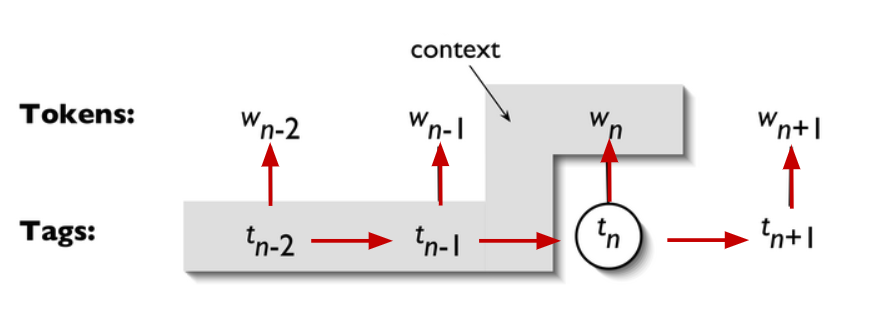
<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transissions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [17]:
A = TOKEN[['pos_group']].join(TOKEN[['pos_group']].shift(-1), lsuffix='_x', rsuffix="_y")\
    .value_counts().to_frame('n').sort_index()

In [18]:
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)

In [19]:
A

n        cp
pos_group_x pos_group_y                
CC          CC            117  0.001402
            CD           1162  0.013925
            DT           9585  0.114859
            EX            442  0.005297
            FW              1  0.000012
...                       ...       ...
WP          MD           1161  0.107779
            NN           1521  0.141199
            RB            525  0.048737
            TO            119  0.011047
            VB           5872  0.545117

[205 rows x 2 columns]

In [20]:
AM = A.cp.unstack(fill_value=0)

In [21]:
AM.style.background_gradient(axis=None, cmap=colors)

pos_group_y,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,
CC,0.001402,0.013925,0.114859,0.005297,0.000012,0.105620,0.088424,0.000000,0.024841,0.248209,0.103583,0.000024,0.010030,0.000012,0.275183,0.008580
CD,0.059794,0.016098,0.009120,0.000397,0.000079,0.168438,0.098652,0.000000,0.018002,0.513561,0.017684,0.000159,0.010706,0.000000,0.078588,0.008723
DT,0.001094,0.009667,0.002046,0.000112,0.000308,0.013202,0.247465,0.000000,0.002676,0.658044,0.028870,0.000142,0.001396,0.000005,0.033426,0.001548
EX,0.002119,0.001324,0.025424,0.000000,0.000000,0.020922,0.010593,0.000000,0.092956,0.016419,0.029396,0.000000,0.001589,0.000000,0.798994,0.000265
FW,0.040816,0.018367,0.175510,0.000000,0.057143,0.022449,0.075510,0.000000,0.006122,0.430612,0.059184,0.002041,0.004082,0.000000,0.108163,0.000000
IN,0.003771,0.012369,0.361609,0.002344,0.000435,0.039046,0.095100,0.000000,0.013906,0.320852,0.024780,0.000117,0.009863,0.000000,0.109041,0.006766
JJ,0.050493,0.005232,0.024156,0.000799,0.000400,0.091696,0.070016,0.000000,0.009120,0.630673,0.021558,0.000418,0.033785,0.000073,0.060127,0.001453
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
MD,0.004674,0.000784,0.011796,0.000063,0.000000,0.013333,0.001286,0.000000,0.000345,0.008094,0.256431,0.000094,0.011890,0.000000,0.691021,0.000188


## Create Table of Initial State Probabilities $\Pi$

We get counts of pos tags that appear at the beginnings of sentences. 

Note: since
we took the trouble to create an OHCO index, we don't need to add `<s>` markers
to find out these frequencies.

In [22]:
PI = TOKEN.query("token_num == 0").pos_group.value_counts().to_frame('n').sort_index()
PI.index.name = 'pos_group'
PI['cp'] = PI.n / PI.n.sum()

## Make sure $\Pi $ shares sample space with $A$ and $B$

Find out what is missing from PI.\
This will be important below.

In [23]:
for tag in (set(AM.index) - set(PI.index)):
    PI.loc[tag, ['n', 'cp']] = (0, 0)

In [24]:
PI

,n,cp
pos_group,,
CC,7864.0,0.107065
CD,743.0,0.010116
DT,9868.0,0.134348
EX,917.0,0.012485
FW,8.0,0.000109
IN,10245.0,0.139481
JJ,4380.0,0.059632
LS,3.0,0.000041
MD,418.0,0.005691


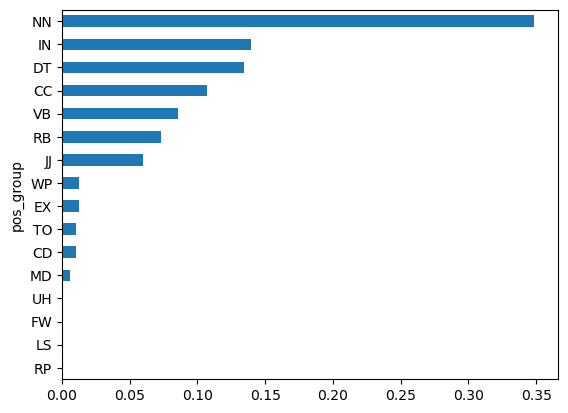

In [25]:
PI.sort_values('cp', ascending=True).cp.plot.barh();

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [26]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n').sort_index()
B.index.names = ['pos_group_y', 'term_str']
B['cp'] = B.n / B.groupby('pos_group_y').n.sum()

In [27]:
B.head()

n        cp
pos_group_y term_str                   
CC          acquired        1  0.000012
            ah              1  0.000012
            all             2  0.000024
            altogether      3  0.000036
            and         60705  0.727442

In [28]:
BM = B.cp.unstack(fill_value=0)

In [29]:
BM

term_str,0,1,10,100,1000,10000,10000000,10440,10800,10th,...,zoroaster,zozo,zuma,zur,à,æneas,æniad,æson,æsops,ł20000
pos_group_y,,,,,,,,,,,,,,,,,,,,,
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000159,0.001348,0.000476,0.000159,0.000159,0.000238,0.000079,0.000079,0.000159,0.000079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Put into single model `HMM`

For convenience, bind the tables into signle model table.

In [30]:
HMM = pd.concat([AM, PI.cp, BM], keys=['trans','start','emit'], axis=1)

In [31]:
# HMM.start

# Prepare Test Data

Import file of raw test sentences.

In [32]:
test_sentences = [s.strip() for s in open(f"{data_home}/misc/test_sentences.txt").readlines()]

Create dataframe of sentences. We will add features here later.

In [33]:
TEST_SENTENCES = pd.DataFrame({'sent_str':test_sentences})
TEST_SENTENCES.index.name = 'sent_id'

In [34]:
TEST_SENTENCES.head()

,sent_str
sent_id,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,but it was a black morning's work for her
4,The want of Miss Taylor would be felt every ho...


Convert sentences to tokens (and terms).

In [35]:
TEST_TOKENS = TEST_SENTENCES.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS.index.names = ['sent_id', 'token_num']
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()

In [36]:
TEST_TOKENS.head()

token_str term_str
sent_id token_num                   
0       0               the      the
        1             quick    quick
        2             brown    brown
        3               fox      fox
        4            jumped   jumped

# The Viterbi Algorithm

The Vertibi implements the optimization function:

<img src="images/formula.png" width="400">

<img src="images/viterbi.png" width="750">

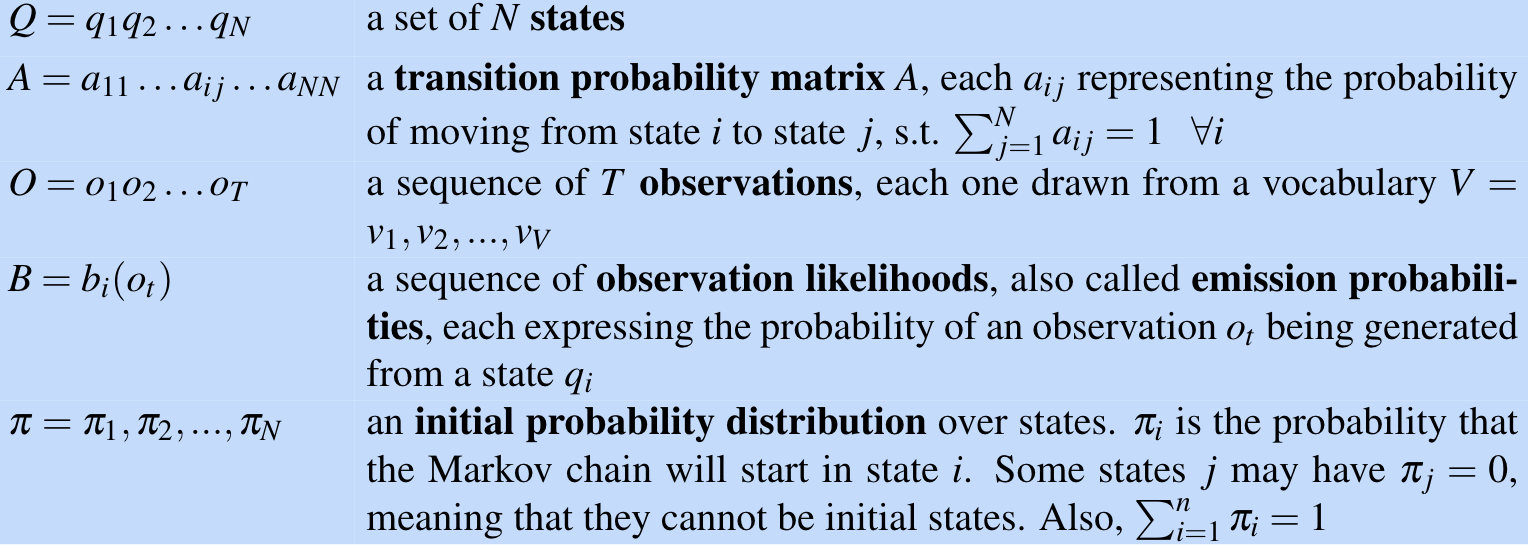

$Q$: "States", i.e. POS tags ($N$ tags)\
$O$: "Observations", i.e. a sequence of $T$ tokens that compose a sentence.\
$A$: POS to POS table $P(q_i|q_{i-1})$\
$B$: POS to word table $P(w_i|q_i)$\
$\pi$: Probability of POS as tag for first token

* `obs` is a list representing the sequence of observed events $O$ 
* `states` is a list of the hidden states $Q$
* `start_prob` is a pandas Series representing the probability distribution over the states at time 0 $\Pi$
* `trans_prob` is a pandas DataFrame representing the transition probability matrix $A$
* `emit_prob` is a pandas DataFrame representing the emission probability matrix $B$

The function returns a list representing the most likely sequence of hidden states that generated the observed events.

## Define function

In [37]:
def viterbi(obs, HMM):
    
    # Import model
    states = HMM.index.to_list()
    start_prob = HMM.start.cp
    trans_prob = HMM.trans
    emit_prob = HMM.emit
    
    # Set up Viterbi lattice
    V = pd.DataFrame(np.zeros((len(states), len(obs))), 
                     columns=range(len(obs)), 
                     index=states)
        
    # Initialize the first observation
    V[0] = start_prob * emit_prob[obs[0]]
    
    # Iterate over the remaining observations
    for t, o in enumerate(obs[1:], start=1):
        for s in states:
            try:
                V.loc[s, t] = (V[t-1] * trans_prob[s] * emit_prob.loc[s, o]).max()
            except KeyError:
                V.loc[s, t] = (V[t-1] * trans_prob[s]).max() # Fallback of word is OOV
    
    return V

In [38]:
test_observations = TEST_TOKENS.loc[TEST_SENTENCES.sample().index[0]].term_str.to_list()

In [39]:
V = viterbi(test_observations, HMM)

In [40]:
pd.concat([pd.Series(test_observations), V.idxmax()], keys=['obs', 'tag'], axis=1).T

,0,1,2,3,4,5,6,7,8,9,10
obs,before,christmas,brought,the,next,visit,from,isabella,and,her,husband
tag,IN,NN,VB,DT,JJ,NN,IN,NN,CC,NN,NN


In [41]:
for w, k in zip(test_observations, V.idxmax().values):
    print(f"{w}/{k}", end=' ')

before/IN christmas/NN brought/VB the/DT next/JJ visit/NN from/IN isabella/NN and/CC her/NN husband/NN 

In [42]:
(V / V.sum()).style.background_gradient(cmap=colors)

,0,1,2,3,4,5,6,7,8,9,10
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988699,0.000000,0.000000
CD,0.000000,0.000000,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.995337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000441,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000005,0.000000,0.003831,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.727654,0.000000,0.000000,0.000026,0.001254,0.002446,0.996739,0.000000,0.000899,0.000000,0.000000
JJ,0.005923,0.017025,0.003116,0.001549,0.953445,0.000000,0.000073,0.000000,0.000220,0.051810,0.009455
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000007,0.000150,0.000000,0.000000,0.000000,0.000025,0.000613,0.000000
NN,0.176697,0.982975,0.013320,0.002583,0.042557,0.948227,0.002427,0.994555,0.008344,0.653978,0.990545


In [43]:
test_observations = TEST_TOKENS.loc[TEST_SENTENCES.sample().index].term_str.to_list()
' '.join(test_observations)

'only half a mile from them'

# ETA Version

This version uses Pandas, but assumes that data are stored in F2 compliant dataframes, i.e. there is TOKENS table.

## Define the function

In [44]:
def viterbi_eta(sent_tokens, verbose=True):
    """
    - _sent_tokens_ must be a selection from an F1 TOKENS table
    """
    
    # Assumes HMM is in scope
    
    # Import model
    TAGS = HMM.index.to_list()
    PI = HMM.start.cp
    AM = HMM.trans
    BM = HMM.emit
    
    # Extract basic data
    ohco = sent_tokens.index.names # Save for return 
    TOKENS = sent_tokens.reset_index() # Reset index so we can access term_str without knowing the OHCO

    # Define dataframes    
    LATTICE = pd.DataFrame(np.zeros((len(TAGS), len(TOKENS)), dtype='float'), index=TAGS, columns=TOKENS.token_num) 
    LATTICE.index.name = 'pos_group'
    
    # Handle first word (NB: fallback net yet implemented)
    first_word = TOKENS.loc[0].term_str
    LATTICE[0] = PI * BM[first_word]

    # Predict the rest of the sentence
    for t in range(1, len(TOKENS)): # Offset of token
        word = TOKENS.loc[t].term_str
        for s in TAGS: # tag name
            if word not in BM.columns:
                b = 1/len(TAGS) # Fallback probability = equiprobable
            else:
                b = BM.loc[s, word]
            LATTICE.loc[s, t] = (LATTICE[t-1] * AM[s] * b).max()

    # Compute results (no need for backpointer, etc.) and bind to TOKENS
    # LATTICE = LATTICE / LATTICE.sum() # Normalize diminishing probs
    TOKENS['tag'] = LATTICE.idxmax()
    TOKENS['prob'] = LATTICE.max()
    TOKENS['i'] = np.log2(1/TOKENS.prob)
    
    if verbose:
        pp = 2**TOKENS.i.mean().round()
        print(" ".join((TOKENS.term_str + '/' + TOKENS.tag).values), f"({pp})")
    
    # Add index back and return
    TOKENS = TOKENS.set_index(ohco)
    return TOKENS

## Try wiith one sentence

In [45]:
# TEST_TOKENS.loc[0] #.loc[0, 'term_str']

In [46]:
x = TEST_SENTENCES.sample().index[0]
# x = 41
X2 = viterbi_eta(TEST_TOKENS.loc[x])

and/CC peculiarly/RB interested/JJ in/IN herself/NN in/IN every/DT pleasure/NN every/DT scheme/NN of/IN hers/NN (1.152921504606847e+18)


In [47]:
X2

,token_str,term_str,tag,prob,i
token_num,,,,,
0,and,and,CC,7.788322e-02,3.682544
1,peculiarly,peculiarly,RB,3.930050e-06,17.957021
2,interested,interested,JJ,3.298908e-10,31.497293
3,in,in,IN,4.093262e-12,37.829886
4,herself,herself,NN,1.275939e-15,49.477362
5,in,in,IN,4.409454e-17,54.332178
6,every,every,DT,2.263922e-19,61.937810
7,pleasure,pleasure,NN,1.516268e-22,72.481894
8,every,every,DT,9.128747e-26,83.179714


## Try with all sentences

In [48]:
TEST = TEST_TOKENS.groupby('sent_id', group_keys=False).apply(lambda x: viterbi_eta(x, False))

In [49]:
TEST.loc[2]

,token_str,term_str,tag,prob,i
token_num,,,,,
0,Mr,mr,NN,2.150213e-03,8.861305
1,Weston,weston,NN,3.319661e-07,21.522461
2,was,was,VB,4.919171e-09,27.598938
3,a,a,DT,1.603133e-10,32.538387
4,man,man,NN,7.373407e-13,40.302734
5,of,of,IN,4.625792e-14,44.297293
6,unexceptionable,unexceptionable,JJ,6.127179e-19,60.501411
7,character,character,NN,3.461044e-22,71.291211
8,easy,easy,JJ,1.095571e-26,86.238447


In [50]:
sample_sentence_id = TEST_SENTENCES.sample().index[0]

In [51]:
sample_sentence_id

29

In [52]:
TEST.loc[sample_sentence_id]

,token_str,term_str,tag,prob,i
token_num,,,,,
0,The,the,DT,7.143544e-02,3.807216
1,evil,evil,NN,1.365731e-05,16.159967
2,of,of,IN,8.568071e-07,20.154526
3,the,the,DT,1.647423e-07,22.533286
4,actual,actual,JJ,1.160332e-11,36.326671
5,disparity,disparity,NN,1.625043e-16,52.450371
6,in,in,IN,5.615906e-18,57.305187
7,their,their,NN,9.336390e-23,73.181481
8,ages,ages,NN,2.667928e-27,88.276339


## What POS tags are hardest to predict?

First, create a dataframe for predict POS tags.

In [53]:
TEST_POS = TEST.groupby('tag').i.mean().to_frame('mean_i')

In [54]:
TEST_POS_IDX = TEST_POS.index
TEST_POS = TEST_POS.merge(POS_GROUP, left_on='tag', right_on='pos_group').set_index(TEST_POS_IDX)
del(TEST_POS_IDX)
TEST_POS['label'] = TEST_POS.index + ' /' + TEST_POS['def'].str.split(r'[,;]').str[0]

In [55]:
TEST_POS

,mean_i,n,def,p,i,h,label
tag,,,,,,,
CC,39.029887,83450,"conjunction, coordinating",0.040530,4.624859,0.187446,CC / conjunction
CD,64.896270,12610,"numeral, cardinal",0.006124,7.351202,0.045022,CD / numeral
DT,44.353822,204813,determiner,0.099474,3.329535,0.331203,DT / determiner
IN,60.731875,264122,"preposition or conjunction, subordinating",0.128279,2.962638,0.380046,IN / preposition or conjunction
JJ,63.466386,165133,"adjective or numeral, ordinal; adjective, co...",0.080202,3.640214,0.291953,JJ / adjective or numeral
MD,54.594215,31876,modal auxiliary,0.015482,6.013300,0.093096,MD / modal auxiliary
NN,63.901893,540387,"noun, common, singular or mass; noun, proper...",0.262457,1.929850,0.506502,NN / noun
RB,55.894620,119059,"adverb; adverb, comparative; adverb, superl...",0.057825,4.112166,0.237785,RB / adverb
TO,45.960520,55581,"""to"" as preposition or infinitive marker",0.026995,5.211179,0.140674,"TO / ""to"" as preposition or infinitive marker"


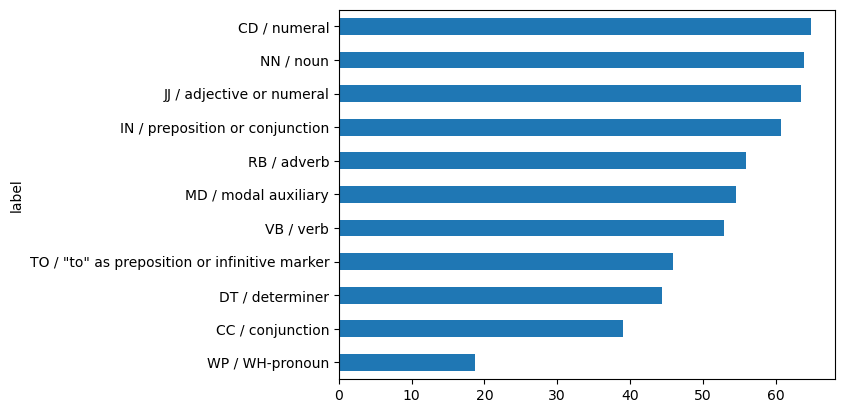

In [56]:
TEST_POS.reset_index().set_index('label').mean_i.sort_values().plot.barh();

## Add features to sentences

In [57]:
TEST['code'] = TEST.apply(lambda x: x.term_str + '/' + x.tag, axis=1) 
TEST_SENTENCES['code'] = TEST.groupby('sent_id').apply(lambda x: ' '.join(x.code))
TEST_SENTENCES['i_mean'] = TEST.groupby('sent_id').i.mean().round(2)
TEST_SENTENCES['pp'] = np.exp2(TEST_SENTENCES.i_mean)

In [58]:
TEST_SENTENCES.sort_values('pp')

,sent_str,code,i_mean,pp
sent_id,,,,
23,and a Miss Taylor in the house,and/CC a/DT miss/NN taylor/NN in/IN the/DT hou...,27.62,2.062759e+08
10,but the intercourse of the last seven years,but/CC the/DT intercourse/NN of/IN the/DT last...,30.88,1.976088e+09
15,interested in all its concerns,interested/JJ in/IN all/DT its/NN concerns/NN,32.14,4.732646e+09
27,but he was no companion for her,but/CC he/NN was/VB no/DT companion/NN for/IN ...,32.69,6.929000e+09
30,and Mr Woodhouse had not married early,and/CC mr/NN woodhouse/NN had/VB not/RB marrie...,33.02,8.709846e+09
22,only half a mile from them,only/RB half/JJ a/DT mile/NN from/IN them/NN,34.80,2.991189e+10
33,without activity of mind or body,without/IN activity/NN of/IN mind/NN or/CC bod...,34.83,3.054040e+10
24,and with all her advantages natural and domestic,and/CC with/IN all/DT her/NN advantages/NN nat...,36.36,8.819636e+10
19,How was she to bear the change,how/NN was/VB she/NN to/TO bear/VB the/DT chan...,37.44,1.864503e+11
